# Problem Statement 

HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities. It runs a lot of operational projects from time to time along with advocacy drives to raise awareness as well as for funding purposes.

 

After the recent funding programmes, they have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. The significant issues that come while making this decision are mostly related to choosing the countries that are in the direst need of aid. 

 

And this is where you come in as a data analyst. Your job is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most.  The datasets containing those socio-economic factors and the corresponding data dictionary are provided below.

In [414]:
# Import the requires Libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


## Read and Visualize the Data

In [415]:
countries = pd.read_csv("Country-data.csv")
countries.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [416]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


In [417]:
countries.shape

(167, 10)

In [418]:
countries.columns.difference(['country'])

Index(['child_mort', 'exports', 'gdpp', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer'],
      dtype='object')

### Check missing values

In [419]:
# We can see no missing values
countries.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

### Derived Metrics

In [420]:
# Convert the percentage columns to absolute values
countries.exports = countries.exports/100 * countries.gdpp
countries.health = countries.health/100 * countries.gdpp
countries.imports = countries.imports/100 * countries.gdpp

In [421]:
# Verify data post conversion
countries.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


### Outlier Detection

- You must perform the Outlier Analysis on the dataset, before or after performing PCA, as per your choice. However, you do have the flexibility of not removing the outliers if it suits the business needs or a lot of countries are getting removed. Hence, all you need to do is find the outliers in the dataset, and then choose whether to keep them or remove them depending on the results you get.

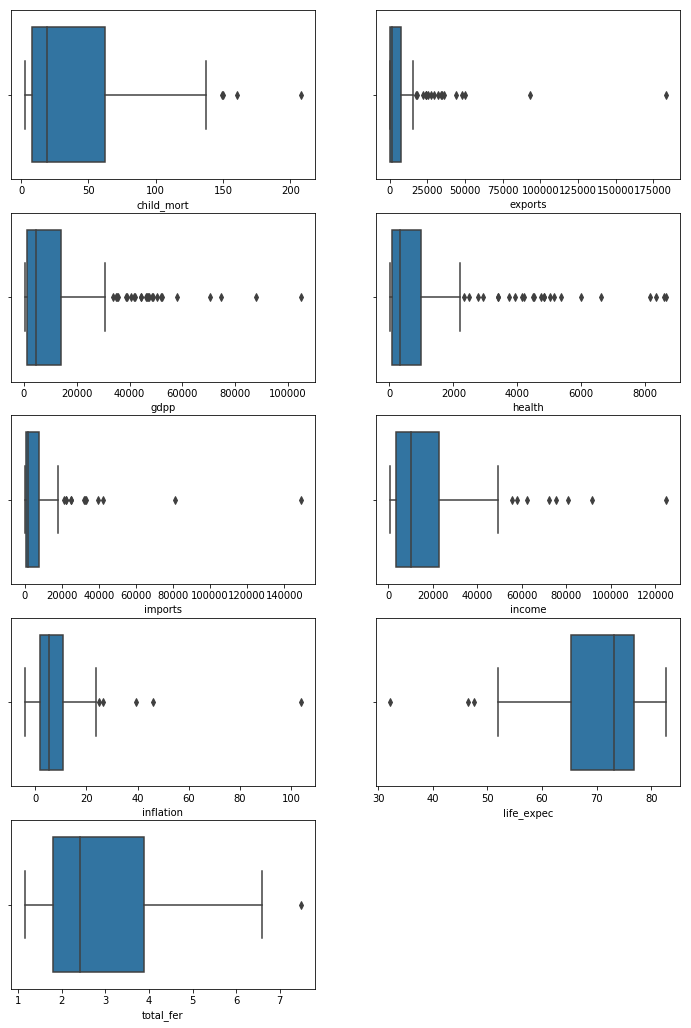

In [422]:
# Get list of numeric columns
num_cols = countries.columns.difference(['country'])

# Create box plots for outlier detection for numeric columns
plt.figure(figsize=(12,18))
for i,col in enumerate(num_cols):
    plt.subplot(5,2,i+1)
    sns.boxplot(x=col,data=countries)
    plt.xlabel(col)

In [423]:
countries.describe(percentiles = [0.01,0.05,0.25,0.50,0.75,0.90,0.95,0.99])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
1%,2.800000,22.243716,17.009362,104.909640,742.240000,-2.348800,47.160000,1.243200,331.620000
5%,3.460000,70.468800,26.715920,169.281000,1213.000000,0.183400,55.780000,1.390000,465.900000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
90%,100.220000,17760.600000,3825.416000,15034.280000,41220.000000,16.640000,80.400000,5.322000,41840.000000


**`There are outliers in most of the columns but We will remove the outliers in the column import and exports as it may affect clustering algoriths. We wont be too aggressive and will only remove countries beyond 1st and 99th percentiles`**

In [424]:
# Removal of outliers in imports column
q1 = countries.imports.quantile(0.01)
q2 = countries.imports.quantile(0.99)
countries = countries[(countries.imports >= q1) & (countries.imports <= q2)]
countries.shape

(163, 10)

In [425]:
# Removal of outliers in exports column
q1 = countries.exports.quantile(0.01)
q2 = countries.exports.quantile(0.99)
countries = countries[(countries.exports >= q1) & (countries.exports <= q2)]
countries.shape

(159, 10)

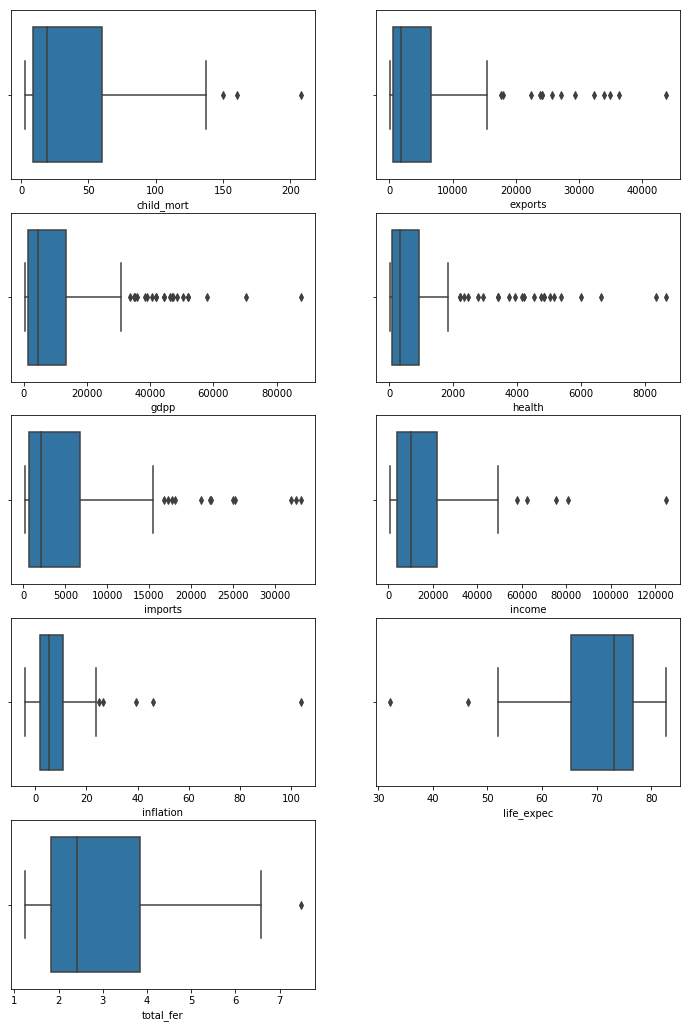

In [426]:
# Check the data post removal of outliers
# Get list of numeric columns
num_cols = countries.columns.difference(['country'])

# Create box plots for outlier detection for numeric columns
plt.figure(figsize=(12,18))
for i,col in enumerate(num_cols):
    plt.subplot(5,2,i+1)
    sns.boxplot(x=col,data=countries)
    plt.xlabel(col)

## Perform PCA on the dataset

- Perform PCA on the dataset and obtain the new dataset with the Principal Components. Choose the appropriate number of components k. You need to perform your clustering activity on this new dataset, i.e. the PCA modified dataset with the k components.

In [427]:
# Create a dataframe by removing the country column
raw_pca_data = countries.drop('country',axis=1)
raw_pca_data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [428]:
# Check variance described by each column in the datset
round(100*raw_pca_data.var()/sum(raw_pca_data.var()),2)

child_mort     0.00
exports       10.03
health         0.38
imports        6.55
income        45.88
inflation      0.00
life_expec     0.00
total_fer      0.00
gdpp          37.15
dtype: float64

In [429]:
#Scale the data prior to applying PCA 
scaler = StandardScaler()
raw_pca_data_scaled = scaler.fit_transform(raw_pca_data)
pd.DataFrame(raw_pca_data_scaled).head()

,0,1,2,3,4,5,6,7,8
0,1.323840,-0.650439,-0.571897,-0.703984,-0.830322,0.138080,-1.666346,1.931562,-0.711266
1,-0.536582,-0.518683,-0.431801,-0.443820,-0.359985,-0.324340,0.662545,-0.865240,-0.489047
2,-0.266113,-0.450086,-0.482583,-0.531661,-0.192088,0.760244,0.685718,-0.033577,-0.465801
3,2.051831,-0.391268,-0.535513,-0.514621,-0.587805,1.348779,-1.214472,2.159598,-0.524230
4,-0.695830,0.013927,-0.141807,0.333639,0.158404,-0.609265,0.720478,-0.543306,0.020481


In [430]:
# Apply PCA
pca = PCA(svd_solver = 'randomized', random_state = 42)
pca.fit(raw_pca_data_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [431]:
# Check the principal components computed by the algorithm
pca.components_

array([[-0.3147328 ,  0.36759026,  0.34609155,  0.37292377,  0.36656834,
        -0.13450379,  0.3396185 , -0.29781528,  0.38790576],
       [ 0.48911524,  0.3174772 ,  0.22161346,  0.23804427,  0.20204335,
         0.29230479, -0.3535028 ,  0.4844551 ,  0.26128974],
       [-0.18960798,  0.00282231, -0.1522362 , -0.09216422,  0.13865755,
         0.920418  ,  0.21864323, -0.13010053, -0.03527761],
       [ 0.00586623,  0.4231839 , -0.74253859,  0.16331593,  0.36870645,
        -0.14359416, -0.17258609, -0.10078425, -0.21526305],
       [ 0.01679677, -0.19971564, -0.04435183, -0.64009126,  0.63093258,
        -0.14814428,  0.10569131,  0.20410734,  0.27439847],
       [ 0.17586702, -0.09996341,  0.16682105, -0.14601994,  0.12938174,
         0.07615735, -0.60227849, -0.71579207,  0.11085928],
       [ 0.77095385, -0.02376577, -0.07407925,  0.02152307,  0.0021847 ,
        -0.02694145,  0.55313234, -0.30209408, -0.03416941],
       [ 0.01191009, -0.2469419 ,  0.35652607,  0.23959424,  0

In [432]:
# Variance ratio explained by PCA components
pca.explained_variance_ratio_

array([0.62432175, 0.16356391, 0.09929685, 0.04492395, 0.02906187,
       0.02558457, 0.0097021 , 0.00213252, 0.00141248])

Text(0.5, 0, 'Number of Principal components')

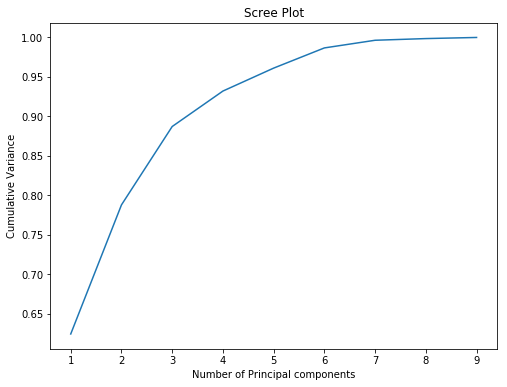

In [433]:
# Scree plot
plt.figure(figsize=(8,6))
sns.lineplot(range(1,10),np.cumsum(pca.explained_variance_ratio_))
plt.title('Scree Plot')
plt.ylabel('Cumulative Variance')
plt.xlabel('Number of Principal components')

In [434]:
np.cumsum(pca.explained_variance_ratio_)

array([0.62432175, 0.78788566, 0.88718251, 0.93210646, 0.96116833,
       0.9867529 , 0.996455  , 0.99858752, 1.        ])

**`We will take 4 principal components for our problem which explains 93% of the variance in the data`**

In [435]:
# We will use Incremental PCA using 4 components 
pca_final = IncrementalPCA(n_components=4)

In [436]:
#Fit the data to the PCA object
country_pca = pca_final.fit_transform(raw_pca_data_scaled)
country_pca.shape

(159, 4)

In [437]:
# convert the data into a dataframe
country_pca = pd.DataFrame(country_pca)
country_pca.columns = ['pc1','pc2','pc3','pc4']
country_pca.head()

,pc1,pc2,pc3,pc4
0,-2.856423,1.361393,-0.663397,0.047678
1,-0.132175,-1.577637,0.125256,-0.020591
2,-0.557189,-0.706783,1.021136,0.196459
3,-2.822465,2.251584,0.385723,0.224545
4,0.853741,-0.944865,-0.181736,-0.197655


# Clustering 
- Try both K-means and Hierarchical clustering(both single and complete linkage) on this dataset to create the clusters. [Note that both the methods may not produce identical results and you might have to choose one of them for the final list of countries.]

In [438]:
#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [439]:
#Verify the Hopkins Measure
hopkins(country_pca)

# The data seems to have good clustering tendency

0.9053683545942103

## K Means Clustering

In [440]:
# Finding the Ideal value for k between 2-9

Text(0.5, 1.0, 'silhouette_score')

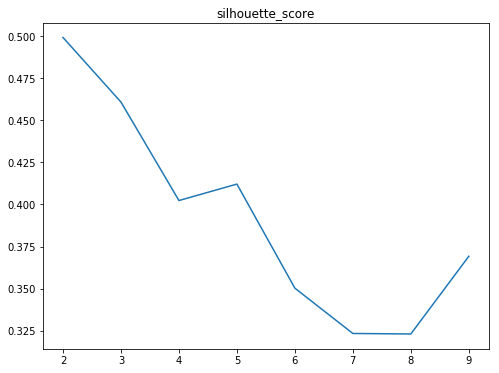

In [441]:
# silhouette_score computation

from sklearn.metrics import silhouette_score
sil_score = []
# Computation of silhouette score for all k
for k in range(2,10):
    kmeans = KMeans(n_clusters=k,random_state=42).fit(country_pca)
    sil_score.append(silhouette_score(country_pca,kmeans.labels_))

plt.figure(figsize=(8,6))
sns.lineplot(range(2,10),sil_score)
plt.title('silhouette_score')

Text(0.5, 1.0, 'Elbow Curve for SSD')

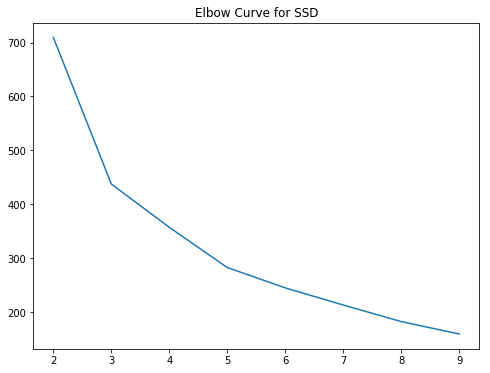

In [442]:
# Elbow curve method to determine optimal value of K
ssd = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k,random_state=42).fit(country_pca)
    ssd.append(kmeans.inertia_)

plt.figure(figsize=(8,6))
sns.lineplot(range(2,10),ssd)
plt.title('Elbow Curve for SSD')    

**`From the elbow curve and silhouette_score analysis k=3 seems to be a good choice for the number of cluster`**

In [443]:
# Applying kmeans clustering with k=3
kmeans = KMeans(n_clusters=3,random_state=42).fit(country_pca)

In [444]:
# Adding the cluster labels to the PCA dataset
country_pca_kmeans = country_pca.copy()
country_pca_kmeans['cluster_ids'] = kmeans.labels_
country_pca_kmeans.head()

,pc1,pc2,pc3,pc4,cluster_ids
0,-2.856423,1.361393,-0.663397,0.047678,2
1,-0.132175,-1.577637,0.125256,-0.020591,1
2,-0.557189,-0.706783,1.021136,0.196459,1
3,-2.822465,2.251584,0.385723,0.224545,2
4,0.853741,-0.944865,-0.181736,-0.197655,1


In [445]:
# Number of countries in each cluster
country_pca_kmeans.cluster_ids.value_counts()

1    81
2    45
0    33
Name: cluster_ids, dtype: int64

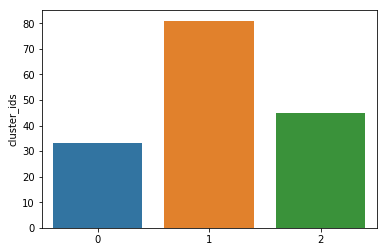

In [446]:
sns.barplot(country_pca_kmeans.cluster_ids.value_counts().index,country_pca_kmeans.cluster_ids.value_counts())

## Visualization using PCA components
- Also, you need to perform visualisations on the clusters that have been formed.  You can do this by choosing the first two Principal Components (on the X-Y axes) and plotting a scatter plot of all the countries and differentiating the clusters.

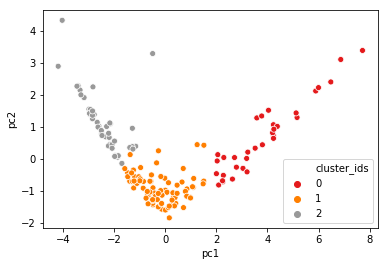

In [447]:
# Visualization of clusters using 2 principal components
sns.scatterplot('pc1','pc2',data=country_pca_kmeans,hue='cluster_ids',palette='Set1')

**`Kmeans seems to be doing a decent job in grouping the countries`**

# Cluster Profiling and Analysis of Clusters - KMeans

- Analyse the clusters and identify the ones which are in dire need of aid. You can analyse the clusters by comparing how these three variables - [gdpp, child_mort and income] vary for each cluster of countries to recognise and differentiate the clusters of developed countries from the clusters of under-developed countries. Note that you perform clustering on the PCA modified dataset and the clusters that are formed are being analysed now using the original variables to identify the countries which you finally want to select.

In [448]:
countries.shape

(159, 10)

In [449]:
countries_kmeans = countries.copy()
countries_kmeans.shape

(159, 10)

In [450]:
country_pca_kmeans.shape

(159, 5)

In [451]:
countries_kmeans['cluster_ids'] = country_pca_kmeans['cluster_ids']

In [452]:
countries_kmeans.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_ids
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,2.0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,1.0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,1.0
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,2.0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,1.0


## Data Visualization using Original Dataset

- You should also do the same visualisation using any two of the original variables (like gdpp, child_mort, etc.) on the X-Y axes as well. You can also choose other types of plots like boxplots, etc. 

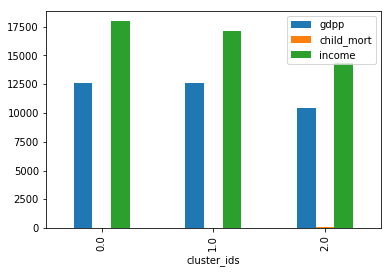

In [453]:
countries_kmeans[['gdpp','child_mort','income','cluster_ids']].groupby('cluster_ids').mean().plot(kind='bar')

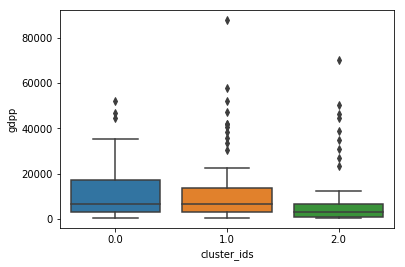

In [454]:
sns.boxplot(x='cluster_ids',y='gdpp',data=countries_kmeans)

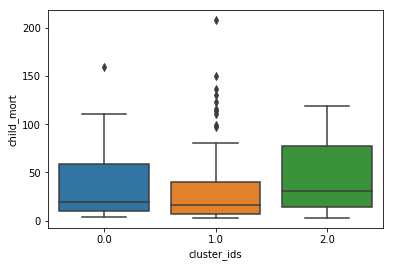

In [455]:
sns.boxplot(x='cluster_ids',y='child_mort',data=countries_kmeans)

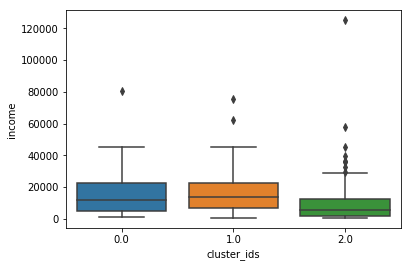

In [456]:
sns.boxplot(x='cluster_ids',y='income',data=countries_kmeans)

### **`It can be clearly observed for countries belonging to cluster group '2' have higher child mortality rates lower gdpp and income per indivisual`**

## Observation

In [457]:
# Final list of countries in cluster group 2 as determined by KMeans
countries_kmeans[countries_kmeans.cluster_ids == 2.0].sort_values('child_mort',ascending=False).country

3                              Angola
25                       Burkina Faso
17                              Benin
63                             Guinea
106                        Mozambique
94                             Malawi
0                         Afghanistan
88                            Liberia
36                            Comoros
56                             Gambia
84                                Lao
142                             Sudan
147                          Tanzania
129                           Senegal
38                        Congo, Rep.
126                            Rwanda
80                              Kenya
69                              India
21                           Botswana
27                           Cambodia
101             Micronesia, Fed. Sts.
120                       Philippines
83                    Kyrgyz Republic
47                              Egypt
30                         Cape Verde
52                               Fiji
141    St. V

# Hierarchical Clustering

In [458]:
# we will be using the scaled PCA of the original dataset
country_pca.head()

,pc1,pc2,pc3,pc4
0,-2.856423,1.361393,-0.663397,0.047678
1,-0.132175,-1.577637,0.125256,-0.020591
2,-0.557189,-0.706783,1.021136,0.196459
3,-2.822465,2.251584,0.385723,0.224545
4,0.853741,-0.944865,-0.181736,-0.197655


#### Single Linkage

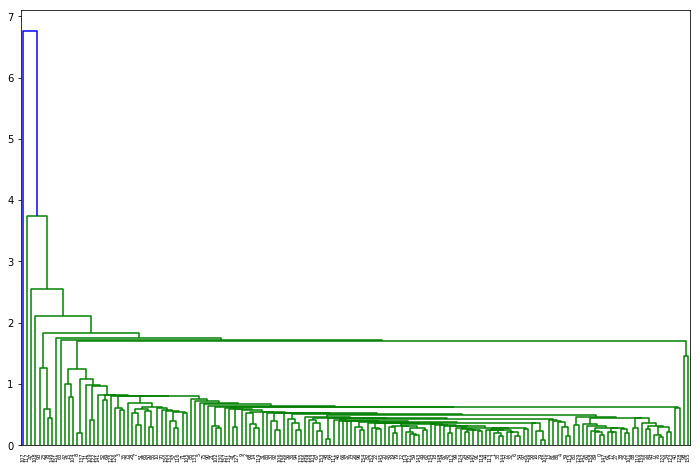

In [459]:
# Hierarchical clustering using single linkage
hs_cluster = linkage(country_pca, method="single", metric='euclidean')
plt.figure(figsize=(12,8))
dendrogram(hs_cluster)
plt.show()

In [460]:
#Getting the results cluster labels
cluster_labels = cut_tree(hs_cluster, n_clusters=4).reshape(-1, )
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [461]:
# Adding the cluster labels to the PCA dataset
country_pca_hier_single = country_pca.copy()
country_pca_hier_single['cluster_ids'] = cluster_labels
country_pca_hier_single.head()

,pc1,pc2,pc3,pc4,cluster_ids
0,-2.856423,1.361393,-0.663397,0.047678,0
1,-0.132175,-1.577637,0.125256,-0.020591,0
2,-0.557189,-0.706783,1.021136,0.196459,0
3,-2.822465,2.251584,0.385723,0.224545,0
4,0.853741,-0.944865,-0.181736,-0.197655,0


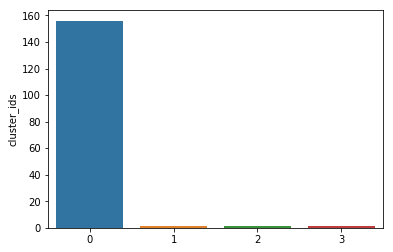

In [462]:
sns.barplot(country_pca_hier_single.cluster_ids.value_counts().index,country_pca_hier_single.cluster_ids.value_counts())

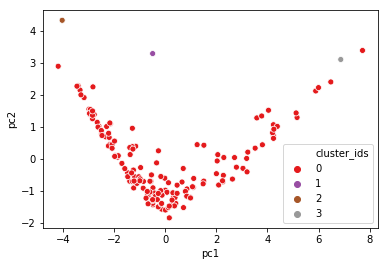

In [463]:
# Visualization of clusters using 2 principal components
sns.scatterplot('pc1','pc2',data=country_pca_hier_single,hue='cluster_ids',palette='Set1')

`Hierarchical clustering with single linkage unable to form reasonable clusters hence ignoring`

#### Complete Linkage

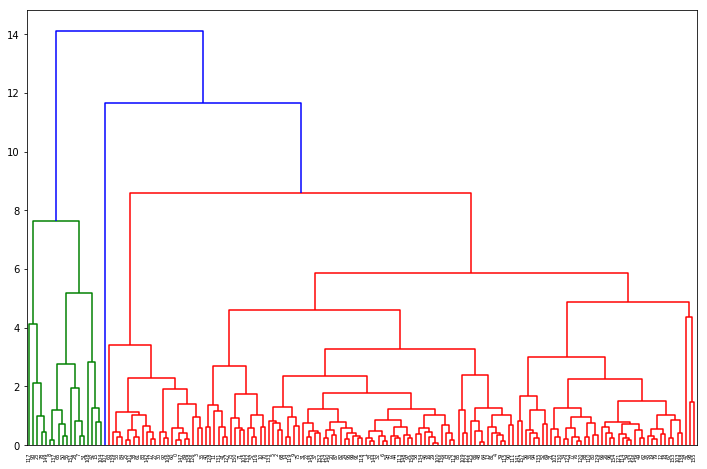

In [464]:
# Hierarchical clustering using complete linkage
hc_cluster = linkage(country_pca,method="complete")
plt.figure(figsize=(12,8))
dendrogram(hc_cluster)
plt.show()

In [465]:
#Getting the results cluster labels
cluster_labels = cut_tree(hc_cluster, n_clusters=4).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1,
       1, 2, 1, 0, 1, 0, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 1, 0, 1, 2, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 0, 3, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 1, 0])

In [466]:
# Adding the cluster labels to the PCA dataset
country_pca_hier_complete = country_pca.copy()
country_pca_hier_complete['cluster_ids'] = cluster_labels
country_pca_hier_complete.head()

,pc1,pc2,pc3,pc4,cluster_ids
0,-2.856423,1.361393,-0.663397,0.047678,0
1,-0.132175,-1.577637,0.125256,-0.020591,1
2,-0.557189,-0.706783,1.021136,0.196459,1
3,-2.822465,2.251584,0.385723,0.224545,0
4,0.853741,-0.944865,-0.181736,-0.197655,1


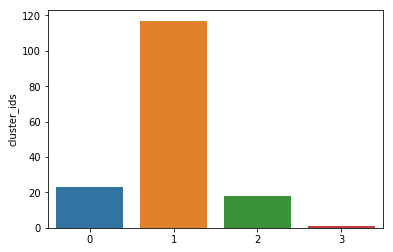

In [467]:
#Getting the total number of countries in each cluster
sns.barplot(country_pca_hier_complete.cluster_ids.value_counts().index,country_pca_hier_complete.cluster_ids.value_counts())

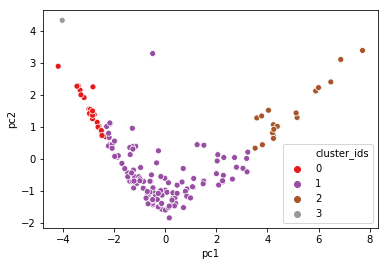

In [468]:
# Visualization of clusters using 2 principal components
sns.scatterplot('pc1','pc2',data=country_pca_hier_complete,hue='cluster_ids',palette='Set1')

# Cluster Profiling and Analysis of Clusters - Hierarchical Clustering

- Analyse the clusters and identify the ones which are in dire need of aid. You can analyse the clusters by comparing how these three variables - [gdpp, child_mort and income] vary for each cluster of countries to recognise and differentiate the clusters of developed countries from the clusters of under-developed countries. Note that you perform clustering on the PCA modified dataset and the clusters that are formed are being analysed now using the original variables to identify the countries which you finally want to select.

In [469]:
countries_hier_comp = countries.copy()
countries_hier_comp.shape

(159, 10)

In [470]:
# Assigning the clusters to original dataset
countries_hier_comp['cluster_ids'] = country_pca_hier_complete['cluster_ids']
countries_hier_comp.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_ids
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0.0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,1.0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,1.0
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0.0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,1.0


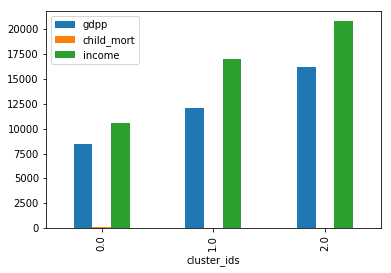

In [471]:
# Mean of socio-economic parameters across clusters
countries_hier_comp[['gdpp','child_mort','income','cluster_ids']].groupby('cluster_ids').mean().plot(kind='bar')

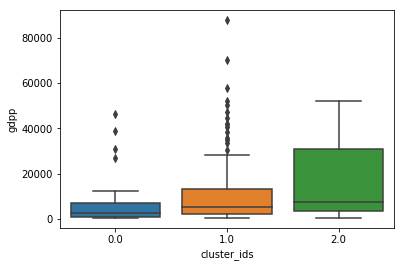

In [472]:
sns.boxplot(x='cluster_ids',y='gdpp',data=countries_hier_comp)

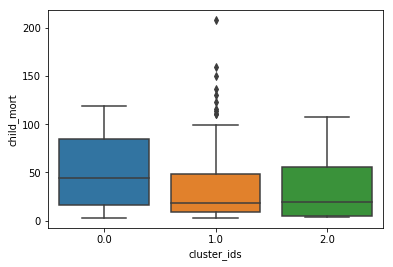

In [473]:
sns.boxplot(x='cluster_ids',y='child_mort',data=countries_hier_comp)

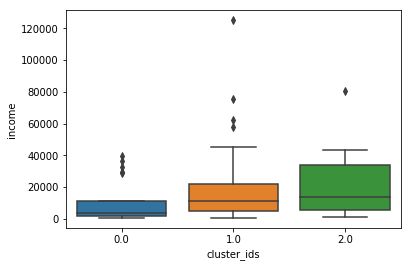

In [474]:
sns.boxplot(x='cluster_ids',y='income',data=countries_hier_comp)

## Using Hierarchical clustering we can see countries belonging to `cluster 0` have low income and gdpp and high child mortality rate

## Observation

In [475]:
# Final list of countries in cluster group 2 as determined by KMeans
countries_hier_comp[countries_hier_comp.cluster_ids == 0.0].sort_values('child_mort',ascending=False).country

3                     Angola
25              Burkina Faso
17                     Benin
63                    Guinea
106               Mozambique
0                Afghanistan
84                       Lao
142                    Sudan
147                 Tanzania
38               Congo, Rep.
126                   Rwanda
27                  Cambodia
101    Micronesia, Fed. Sts.
83           Kyrgyz Republic
30                Cape Verde
35                  Colombia
89                     Libya
61                   Grenada
92            Macedonia, FYR
158           United Kingdom
60                    Greece
139                    Spain
53                   Finland
Name: country, dtype: object

### Using Hierarchical clustering instead of KMeans clustering as it has narrowed down the list of developing countries cluster to 20. 

**`Below is the list of countries requiring aid from HELP International`**

 - Angola
 - Burkina Faso
 -     Benin
 -      Guinea
 -  Mozambique
 -  Afghanistan
 -         Lao
 -       Sudan
 -    Tanzania
 - Congo, Rep.
